In [1]:
import numpy as np
from datetime import datetime
import cv2
import os
from PIL import Image
import torch
import torchvision
from torchvision import datasets, transforms, models
from dataset import Asbest_segmentation
from tqdm import tqdm
import matplotlib.pyplot as plt
import rawpy
import segmentation_models_pytorch as smp
from utils import parse_anno_file, create_mask_file, big_image_predict, get_time, true_results
from apex import amp

# os.environ['CUDA_VISIBLE_DEVICES'] = '0'

device = torch.device("cuda:" + str(torch.cuda.device_count() - 1) if torch.cuda.is_available() else "cpu")

model_asbest = smp.Unet(encoder_name='efficientnet-b3', in_channels=1, classes=2, activation='sigmoid').to(device)
model_asbest.load_state_dict(torch.load('asbest_segmentation_b3_v2.pth'))
model_asbest.eval();

In [2]:
def calculate_info(img_pathes, model):
    results = []
    for obj in img_pathes:
        img = cv2.imread(obj, cv2.IMREAD_UNCHANGED)
        img, st, asb = big_image_predict(model, 
                                         img,
                                         crop_size=(1024, 1024),
                                         inp_size=(1024, 1024),
                                         device=device
                                        )
        results.append(100 * len(np.where(asb > 0.5)[0]) / img.shape[0] / img.shape[1])
    return results

In [3]:
dist_norm = lambda x : np.exp(- x ** 2 / 2) / (2 * np.pi) ** (1/2) 

def pz_approx(a, h, kernel, nums):
    t = np.linspace(min(a), max(a), nums)
    f = np.zeros(t.shape)
    for i in range(len(t)):
        for j in range(len(a)):
            f[i] += 1 / (len(a) * h) * np.sum(kernel((t[i] - a[j]) / h))
    return f

def get_quartiles(x, a):
    y = np.cumsum(a) / np.sum(a)
    indexes = np.argsort(abs(y - 0.05))[:2]
    q5 = x[indexes][0]
    indexes = np.argsort(abs(y - 0.5))[:2]
    q50 = x[indexes][0]
    indexes = np.argsort(abs(y - 0.95))[:2]
    q95 = x[indexes][0]
    return q5, q50, q95

def get_h(dist, h=0.01):
    direction = 1e-4
    a = np.array(dist)
    f = -np.Inf
    flag = True
    while abs(direction) >= 1e-5: 
        l = []
        h += direction
        if h <= 0:
            print('!')
            break 
        for i in range(len(a)):
            l.append(np.log(np.sum([dist_norm((a[i] - a[j]) / h) for j in range(len(a)) if i != j]) / (len(a) - 1) / h))
        r = np.sum(l) / len(a)              
        if r < f:
            h -= direction
            if flag:
                direction = -direction
                flag = False
            else:
                direction = direction * 1e-1
        else:
            f = r
    return h

def plot_dist_pz(dist, h, num_points = 200):
    a = np.array(dist)
    hist, x, *_ = np.histogram(a, bins=10);
    hist = hist / sum(hist) / (x[1] - x[0])
    plt.bar([(x[i] + x[i+1]) / 2 for i in range(len(x) - 1)], hist, width=(x[1] - x[0]))
    t = np.linspace(np.min(a), np.max(a), num_points)
    f = pz_approx(a, h, dist_norm, num_points)
    q5, q50, q95 = get_quartiles(t, f)
    plt.plot(t, f, 'r')
    plt.xlabel('Содержание асбеста, %')
    plt.vlines(np.array([q5, q50, q95]), 0, max(hist))
    print('Квартиль на уровне доверительной вероятности 0.05 = ', q5)
    print('Квартиль на уровне доверительной вероятности 0.50 = ', q50)
    print('Квартиль на уровне доверительной вероятности 0.95 = ', q95)
    return q5, q50, q95

In [4]:
path = 'asbestos/stones/230321/'

data = {
    '23-03-21' : 
    { 1 : 
     { 
         'content' : 0.025,
         'images' : {},
     },
     2 : 
     { 
         'content' : 0.035,
         'images' : {},
     },
     3 : 
     { 
         'content' : 0.025,
         'images' : {},
     }
    },
}

In [5]:
for pit in os.listdir(path):
    for i, case in enumerate(os.listdir(os.path.join(path, pit))):
        data['23-03-21'][int(pit)]['images'][i] = [os.path.join(path, pit, case, file) for file in os.listdir(os.path.join(path, pit, case)) if file.endswith('detailed.bmp')]

## Забой № 1 (съемка 1) от 23.03.21. Содержание 2.5%

In [6]:
res_230321_1_1 = calculate_info(data['23-03-21'][1]['images'][0], model_asbest)

In [7]:
h = get_h(res_230321_1_1)
print(h)

0.15307999999999944


Квартиль на уровне доверительной вероятности 0.05 =  0.2759664509371704
Квартиль на уровне доверительной вероятности 0.50 =  0.6896469047106676
Квартиль на уровне доверительной вероятности 0.95 =  1.5592201034590394
Среднее:  0.7538153200733418


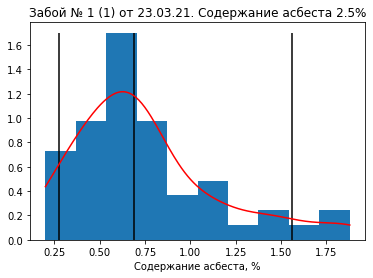

In [8]:
_, q50, _ = plot_dist_pz(res_230321_1_1, h)
# q50s['02-02-21'][1] = q50
print('Среднее: ', np.mean(res_230321_1_1))
plt.title('Забой № 1 (1) от 23.03.21. Содержание асбеста 2.5%')
plt.savefig('graphics/pit_1_1_230321.png',bbox_inches='tight', pad_inches=0)

## Забой № 1 (съемка 2) от 23.03.21. Содержание 2.5%

In [9]:
res_230321_1_2 = calculate_info(data['23-03-21'][1]['images'][1], model_asbest)

In [10]:
h = get_h(res_230321_1_2)
print(h)

0.16507999999999812


Квартиль на уровне доверительной вероятности 0.05 =  0.18161499394517922
Квартиль на уровне доверительной вероятности 0.50 =  0.6531733911588711
Квартиль на уровне доверительной вероятности 0.95 =  1.1247317883725632
Среднее:  0.6709553282937886


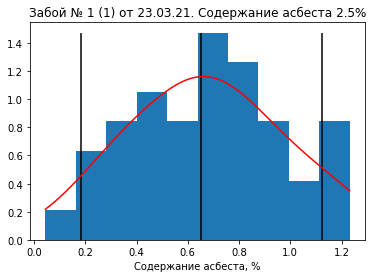

In [11]:
_, q50, _ = plot_dist_pz(res_230321_1_2, h)
# q50s['02-02-21'][2] = q50
print('Среднее: ', np.mean(res_230321_1_2))
plt.title('Забой № 1 (1) от 23.03.21. Содержание асбеста 2.5%')
plt.savefig('graphics/pit_1_2_230321.png',bbox_inches='tight', pad_inches=0)

## Забой № 2 (съемка 1) от 23.03.21. Содержание 3.5%

In [12]:
res_230321_2_1 = calculate_info(data['23-03-21'][2]['images'][0], model_asbest)

In [13]:
h = get_h(res_230321_2_1)
print(h)

0.1654999999999981


Квартиль на уровне доверительной вероятности 0.05 =  0.28104551954167056
Квартиль на уровне доверительной вероятности 0.50 =  0.6907279604281051
Квартиль на уровне доверительной вероятности 0.95 =  1.2729082711614594
Среднее:  0.7038290033895501


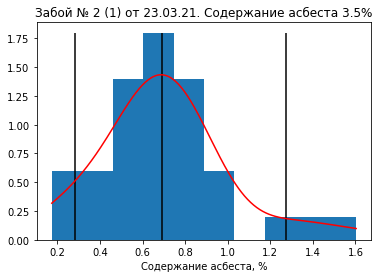

In [14]:
_, q50, _ = plot_dist_pz(res_230321_2_1, h)
# q50s['16-12-20'][1] = q50
print('Среднее: ', np.mean(res_230321_2_1))
plt.title('Забой № 2 (1) от 23.03.21. Содержание асбеста 3.5%')
plt.savefig('graphics/pit_2_1_230321.png',bbox_inches='tight', pad_inches=0)

## Забой № 2 (съемка 2) от 23.03.21. Содержание 3.5%

In [15]:
res_230321_2_2 = calculate_info(data['23-03-21'][2]['images'][1], model_asbest)

In [ ]:
h = get_h(res_230321_2_2)
print(h)

In [ ]:
_, q50, _ = plot_dist_pz(res_230321_2_2, h)
# q50s['16-12-20'][2] = q50
print('Среднее: ', np.mean(res_230321_2_2))
plt.title('Забой № 2 (2) от 23.03.21. Содержание асбеста 3.5%')
plt.savefig('graphics/pit_2_2_230321.png',bbox_inches='tight', pad_inches=0)

## Забой № 3 от 23.03.21. Содержание 2.5%

In [18]:
res_230321_3_1 = calculate_info(data['23-03-21'][3]['images'][0], model_asbest)

In [19]:
h = get_h(res_230321_3_1)
print(h)

/home/vasily/.virtualenvs/cnn_course/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log


0.31488999999998163


Квартиль на уровне доверительной вероятности 0.05 =  0.26891260971257713
Квартиль на уровне доверительной вероятности 0.50 =  1.0337358639564043
Квартиль на уровне доверительной вероятности 0.95 =  2.167313187210648
Среднее:  1.074567060982379


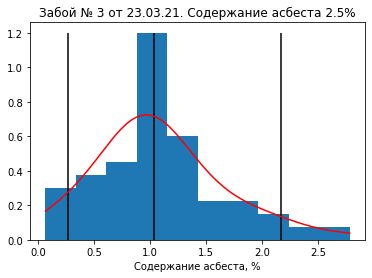

In [20]:
_, q50, _ = plot_dist_pz(res_230321_3_1, h)
# q50s['16-12-20'][1] = q50
print('Среднее: ', np.mean(res_230321_3_1))
plt.title('Забой № 3 от 23.03.21. Содержание асбеста 2.5%')
plt.savefig('graphics/pit_3_1_230321.png',bbox_inches='tight', pad_inches=0)

 ## График зависимостей

In [21]:
q50s

NameError: name 'q50s' is not defined

In [ ]:
content = []
lst_50 = []
for date in q50s.keys():
    for pit in q50s[date].keys():
        if date == '16-12-20' and (pit == 2 or pit == 3):
            continue
        lst_50.append(q50s[date][pit])
        content.append(data[date][pit]['content'])

t = [min(lst_50), max(lst_50)]
p = np.polyfit(lst_50, content, 1)
y = np.polyval(p, t)
print(p)
        
        
plt.scatter(lst_50, content)
plt.plot(t, y)

plt.xlabel('Медианы распределений')
plt.ylabel('Содержание асбеста')
plt.savefig('graphics/content_asbest.png', bbox_inches='tight', pad_inches=0)